In [10]:
import numpy as np 
import pandas as pd
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib
import matplotlib.pyplot as plt
import PIL
from PIL import Image
import os

In [2]:
display(f"pytorch version: {torch.__version__}")
display(f"numpy version: {np.__version__}")
display(f"pandas version: {pd.__version__}")
display(f"matplotlib version: {matplotlib.__version__}")
display(f"pillow version: {PIL.__version__}")
display("-"*50)
display(f"CUDA Is Available : {torch.cuda.is_available()}")

'pytorch version: 2.9.0+cu128'

'numpy version: 2.3.4'

'pandas version: 2.3.3'

'matplotlib version: 3.10.7'

'pillow version: 12.0.0'

'--------------------------------------------------'

'CUDA Is Available : True'

In [3]:
labels_path = "roll_number_dataset2/labels.csv"
image_folder_root = "roll_number_dataset2/"

In [4]:
df = pd.read_csv(labels_path)
df.head(4)

,image_path,label
0,images/134712536281_0.png,134712536281
1,images/057665706184_1.png,57665706184
2,images/236070779846_2.png,236070779846
3,images/143539849576_3.png,143539849576


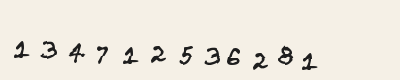

In [5]:
sample_image = Image.open(os.path.join(image_folder_root, df['image_path'][0]))
sample_image

In [6]:
sample_image_np = np.array(sample_image)
display(f"image shape : {sample_image_np.shape}")
sample_image_np[0]

'image shape : (80, 400, 3)'

array([[245, 240, 230],
       [245, 240, 230],
       [245, 240, 230],
       ...,
       [245, 240, 230],
       [245, 240, 230],
       [245, 240, 230]], shape=(400, 3), dtype=uint8)

In [7]:
# so the image is unnormalized & is organized as height x width x channels
# we need only black & white images
sample_image_gs = sample_image.convert("L")
# 255.0 is normalization constant 
sample_image_gs_np = np.array(sample_image_gs, dtype=np.float32) / 255.0
display(f"sample image (greyscaled) shape : {sample_image_gs_np.shape}")
sample_image_gs_np

'sample image (greyscaled) shape : (80, 400)'

array([[0.9411765, 0.9411765, 0.9411765, ..., 0.9411765, 0.9411765,
        0.9411765],
       [0.9411765, 0.9411765, 0.9411765, ..., 0.9411765, 0.9411765,
        0.9411765],
       [0.9411765, 0.9411765, 0.9411765, ..., 0.9411765, 0.9411765,
        0.9411765],
       ...,
       [0.9411765, 0.9411765, 0.9411765, ..., 0.9411765, 0.9411765,
        0.9411765],
       [0.9411765, 0.9411765, 0.9411765, ..., 0.9411765, 0.9411765,
        0.9411765],
       [0.9411765, 0.9411765, 0.9411765, ..., 0.9411765, 0.9411765,
        0.9411765]], shape=(80, 400), dtype=float32)

In [8]:
sample_image_unravelled = sample_image_gs_np.ravel()
sample_image_unravelled.shape

(32000,)

In [18]:
class OCRImageDataset(torch.utils.data.Dataset):
    def __init__(self, image_folder_root, labels_path):
        super().__init__()
        # image root folder
        self.image_folder_root = image_folder_root

        # labels dataframe (remove digits which are not of 12 digits)
        df = pd.read_csv(labels_path)
        df['label'] = df['label'].astype(str)
        self.labels_df = df[df['label'].str.len() == 12].reset_index(drop=True)
        print(f"Original size: {len(df)}, Filtered size: {len(self.labels_df)}")

        # transformation for data augmentation & image normalization 
        self.transform = transforms.Compose([
            transforms.Grayscale(num_output_channels=1),
            transforms.ToTensor()
        ])

        # character mapping to digit
        char_set = "0123456789"
        self.char_map = {char:i for i, char in enumerate(char_set)}

    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx):
        image_i = Image.open(os.path.join(self.image_folder_root, self.labels_df['image_path'][idx]))
        image_i = self.transform(image_i)

        image_i = image_i.ravel()

        label_i = [self.char_map[char] for char in str(self.labels_df['label'][idx])]
        label_i = torch.tensor(label_i, dtype=torch.long)
        return image_i, label_i

dataset = OCRImageDataset(image_folder_root, labels_path)

dataloader = torch.utils.data.DataLoader(dataset, batch_size=128, num_workers=4, persistent_workers=True)

for image, labels in dataloader:
    display(image.shape)
    display(labels.shape)
    break

Original size: 10000, Filtered size: 9040


torch.Size([128, 32000])

torch.Size([128, 12])

In [20]:
class ClassifierV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.ff = nn.Sequential(
            nn.Linear(32000, 4096),
            nn.ReLU(),
            nn.Linear(4096, 2048),
            nn.ReLU(),
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Linear(1024, 120)
        )

    def forward(self, x):
        return self.ff(x)

model = ClassifierV1()
model

ClassifierV1(
  (ff): Sequential(
    (0): Linear(in_features=32000, out_features=4096, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4096, out_features=2048, bias=True)
    (3): ReLU()
    (4): Linear(in_features=2048, out_features=1024, bias=True)
    (5): ReLU()
    (6): Linear(in_features=1024, out_features=120, bias=True)
  )
)

In [21]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
loss_function = nn.CrossEntropyLoss()

debug = False
device = torch.device("cuda")

model = model.to(device)

for epoch in range(50):
    epoch_loss = 0.0
    print(f"epoch {epoch + 1} started | ", end=" ")
    for images, labels in dataloader:
        images = images.to(device)
        labels = labels.to(device)

        if debug:
            display(f"images.shape : {images.shape}")
            display(f"labels.shape : {labels.shape}")
        y_hat = model(images)
        y = labels

        if debug:
            display(f"y.shape : {y.shape}")
            display(f"y_hat.shape : {y_hat.shape}")

        y_hat = y_hat.view(-1, 10)
        y = y.view(-1)

        if debug: 
            display(f"y.shape (reshaped): {y.shape}")
            display(f"y_hat.shape (reshaped): {y_hat.shape}")

        loss = loss_function(y_hat, y)
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()

    print(f"loss = {epoch_loss}")

epoch 1 started |  

RuntimeError: DataLoader worker (pid(s) 50228, 50229, 50230, 50231) exited unexpectedly